# Dependency

In [71]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb # datareader supports multiple financial database including yahoo and google
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline

# Data Fetching
## Start & End Date

In [2]:
date_rang_month = 3
start_date = datetime.date.today() + relativedelta(months=-date_rang_month)
end_date = datetime.date.today()

## Tesla Stock

In [4]:
def data_loader(tickers):
    stock_dfs = list()
    for ticker, source in tickers:
        if source == "fred":
            df = pd.DataFrame(wb.DataReader(ticker, 
                                            data_source = source, 
                                            start = start_date + relativedelta(days = -1), 
                                            end = end_date))
        else:
            df = pd.DataFrame(wb.DataReader(ticker, 
                                            data_source = source, 
                                            start = start_date, 
                                            end = end_date))
        stock_dfs.append(df)
    return stock_dfs

In [7]:
tickers = \
[
    ("TSLA", "yahoo"), # 0, TESLA Stock
]

tsla_df = data_loader(tickers)[0]
time_series = tsla_df["Close"]



# Data Cleaning
Simply, we assume that there are no typos in our dataframes.

In [15]:
if np.sum(time_series.isnull()) > 0:
    print("The time series contain missing values & we use interpolation to resolve this issue")
    time_series = time_series.interpolate(method='polynomial', order=2, limit_direction='forward', axis=0)
# Then, if there is still some missing values, we simply drop this value.abs
time_series = time_series.dropna()



# Data Splitting

In [51]:
train = time_series[0:round(len(time_series) * 2/ 3)]
test = time_series[round(len(time_series) * 2 / 3):len(time_series)]

# Data Processing
## Check If Stationary

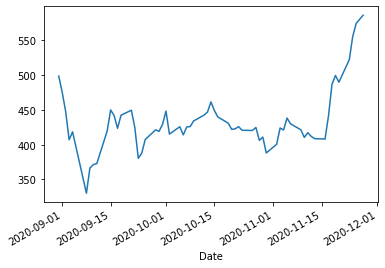

In [57]:
# plot the time series
time_series.plot()

In [56]:
time_series_adf = ADF(time_series.to_list())
print("timeserise_adf: " + str(time_series_adf))

timeserise_adf: (0.7713548399336475, 0.9911594242615474, 6, 56, {'1%': -3.552928203580539, '5%': -2.9147306250000002, '10%': -2.595137155612245}, 435.705567417015)


From above plot, it seems that the time series are not stationary. Also, the statistics given from ADF test shows that there is no evidence to reject the null hypothesis that the time series are not stationary. Therefore, we should perform time series decomposition to firstly extract trend, seasonality and residual series from the original series.

## Time Series Decomposition

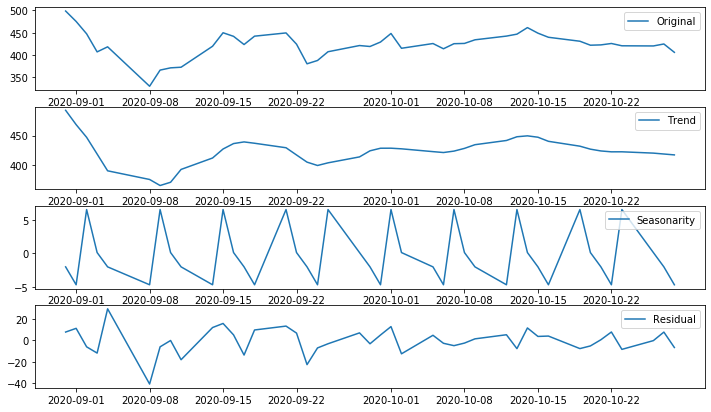

In [75]:
season_period = 4
def decomposing(timeseries):
    decomposition = seasonal_decompose(timeseries, model='additive', extrapolate_trend='freq', period=season_period)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(12, 7))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonarity')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.show()

    return trend, seasonal, residual

train.indexes = train.reset_index()["Date"].apply(pd.to_datetime) # transform times series' index to type Datetime
trend_train, seasonal_train, residual_train = decomposing(train)

## ADF Check Again

In [81]:
def diff(timeseries):
    timeseries_diff1 = timeseries.diff(1)
    timeseries_diff2 = timeseries_diff1.diff(1)

    timeseries_diff1 = timeseries_diff1.fillna(0)
    timeseries_diff2 = timeseries_diff2.fillna(0)

    timeseries_adf = ADF(timeseries.tolist())
    timeseries_diff1_adf = ADF(timeseries_diff1.tolist())
    timeseries_diff2_adf = ADF(timeseries_diff2.tolist())

    print('timeseries_adf : ', timeseries_adf)
    print('timeseries_diff1_adf : ', timeseries_diff1_adf)
    print('timeseries_diff2_adf : ', timeseries_diff2_adf)

    plt.figure(figsize=(10, 5))
    plt.plot(timeseries, label='Original', color='blue')
    plt.plot(timeseries_diff1, label='Diff1', color='red')
    plt.plot(timeseries_diff2, label='Diff2', color='purple')
    plt.legend(loc='best')
    plt.show()

timeseries_adf :  (-4.772433398407113, 6.138907090395638e-05, 2, 39, {'1%': -3.610399601308181, '5%': -2.939108945868946, '10%': -2.6080629651545038}, 134.4726348596969)
timeseries_diff1_adf :  (-4.026801229060333, 0.0012764945688513633, 1, 40, {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}, 136.76065402689034)
timeseries_diff2_adf :  (-4.926522408643529, 3.095740841369498e-05, 7, 34, {'1%': -3.639224104416853, '5%': -2.9512301791166293, '10%': -2.614446989619377}, 147.53498820666397)


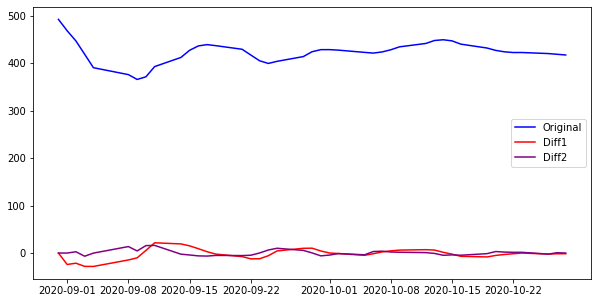

In [82]:
diff(trend_train)

timeseries_adf :  (-4.830837445984679, 4.7460744769795975e-05, 9, 32, {'1%': -3.653519805908203, '5%': -2.9572185644531253, '10%': -2.6175881640625}, 217.68727175537447)
timeseries_diff1_adf :  (-4.850460248929708, 4.350380788720785e-05, 9, 32, {'1%': -3.653519805908203, '5%': -2.9572185644531253, '10%': -2.6175881640625}, 227.30811877669996)
timeseries_diff2_adf :  (-4.412783007899715, 0.0002817463383924394, 10, 31, {'1%': -3.661428725118324, '5%': -2.960525341210433, '10%': -2.6193188033298647}, 244.115946759476)


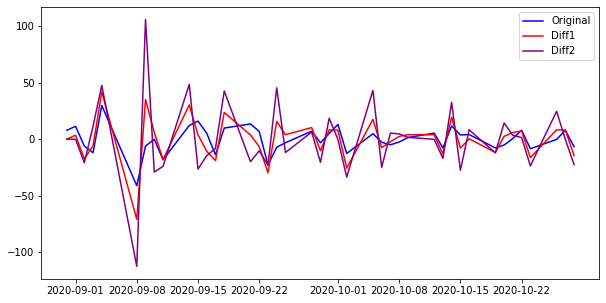

In [83]:
diff(residual_train)

Clearly, from above plots, both series are stationary which fits our assumption for arima model

# ARIMA model
## Find p, d, q

In [84]:
trend_evaluate = sm.tsa.arma_order_select_ic(trend_train, ic=['aic', 'bic'], trend='nc', max_ar=4,
                                            max_ma=4)
print('trend AIC', trend_evaluate.aic_min_order)
print('trend BIC', trend_evaluate.bic_min_order)

D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\

In [85]:
residual_evaluate = sm.tsa.arma_order_select_ic(residual_train, ic=['aic', 'bic'], trend='nc', max_ar=4,
                                            max_ma=4)
print('residual AIC', residual_evaluate.aic_min_order)
print('residual BIC', residual_evaluate.bic_min_order)

D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\JI\software\Anaconda\l

## ARIMA Construction

In [86]:
def ARIMA_Model(timeseries, order):
    model = ARIMA(timeseries, order=order)
    return model.fit(disp=0)

In [88]:
trend_model = ARIMA_Model(trend_train, (2, 0, 4))
residual_model = ARIMA_Model(residual_train, (1, 0, 1))


D:\JI\software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


## Model Summary

In [129]:
print(residual_model.summary())

ARMA Model Results                              
Dep. Variable:                  resid   No. Observations:                   42
Model:                     ARMA(1, 1)   Log Likelihood                -158.165
Method:                       css-mle   S.D. of innovations             10.115
Date:                Mon, 30 Nov 2020   AIC                            324.330
Time:                        10:52:36   BIC                            331.281
Sample:                             0   HQIC                           326.878
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1801      0.224     -0.805      0.421      -0.619       0.258
ar.L1.resid     0.4782      0.139      3.432      0.001       0.205       0.751
ma.L1.resid    -0.9999      0.071    -14.057      0.000      -1.139      -0.86

In [130]:
print(trend_model.summary())

ARMA Model Results                              
Dep. Variable:                  trend   No. Observations:                   42
Model:                     ARMA(2, 4)   Log Likelihood                -112.328
Method:                       css-mle   S.D. of innovations              3.033
Date:                Mon, 30 Nov 2020   AIC                            240.656
Time:                        10:52:55   BIC                            254.558
Sample:                             0   HQIC                           245.752
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         425.6857      4.553     93.496      0.000     416.762     434.609
ar.L1.trend     1.7366      0.085     20.446      0.000       1.570       1.903
ar.L2.trend    -0.9171      0.076    -12.116      0.000      -1.065      -0.76

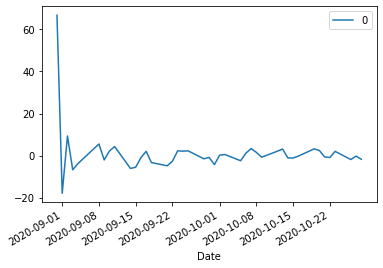

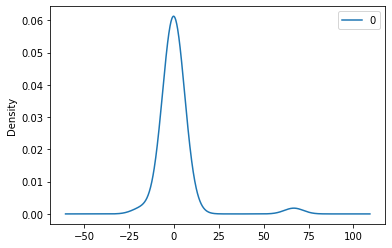

0
count  42.000000
mean    1.022860
std    11.220602
min   -17.990233
25%    -2.055890
50%    -0.475654
75%     2.123010
max    66.772961


In [132]:
residuals = pd.DataFrame(trend_model.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

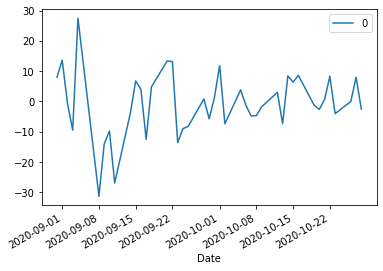

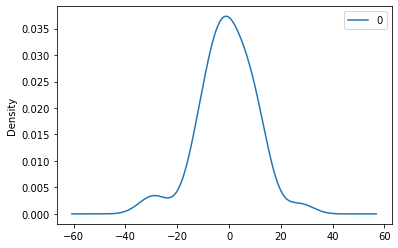

0
count  42.000000
mean   -0.713679
std    10.724544
min   -31.299758
25%    -6.918752
50%    -0.910443
75%     6.709941
max    27.460034


In [133]:
residuals = pd.DataFrame(residual_model.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Prediction

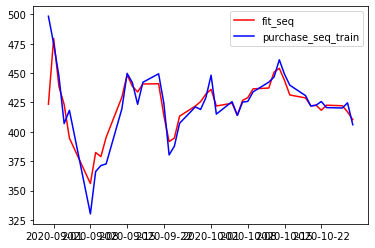

In [90]:
trend_fit_seq = trend_model.fittedvalues
residual_fit_seq = residual_model.fittedvalues

fit_seq = seasonal_train
fit_seq = fit_seq.add(trend_fit_seq, fill_value=0)
fit_seq = fit_seq.add(residual_fit_seq, fill_value=0)

plt.plot(fit_seq, color='red', label='fit')
plt.plot(train, color='blue', label='train')
plt.legend(loc='best')
plt.show()

D:\JI\software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\JI\software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


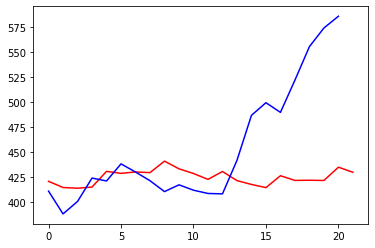

In [128]:
residual_predict_seq = residual_model.predict(start=len(train), end=len(train)+len(test), dynamic=True).reset_index().iloc[:, 1]
trend_predict_seq = trend_model.predict(start=len(train), end=len(train)+len(test), dynamic=True).reset_index().iloc[:, 1]
seasonal_predict_seq = seasonal_train[pd.Timestamp("2020-09-02"):pd.Timestamp("2020-10-01")]

predict_seq = seasonal_predict_seq.reset_index()["seasonal"]
predict_seq = predict_seq.add(trend_predict_seq, fill_value=0)
predict_seq = predict_seq.add(residual_predict_seq, fill_value=0)

plt.plot(predict_seq, color='red', label='prediction')
plt.plot(test.reset_index().iloc[:, 1], color='blue', label='test')
# plt.legend(loc='best')
# plt.show()
